In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from missforest import MissForest
from scipy.stats import ks_2samp
from sklearn.metrics import mean_absolute_error
import random
from sklearn.impute import KNNImputer


In [2]:
def plot_distributions(original, imputed, variable):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(original[variable].dropna(), label='Original', color='blue')
    sns.kdeplot(imputed[variable], label='Imputed', color='red')
    plt.title(f'Distribution of {variable}')
    plt.legend()
    plt.show()


In [3]:
# Load the dataset
data = pd.read_csv('rad_clin_feats_PFS_OS.csv')

# Explore the data
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Columns: 1146 entries, MPC to wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
dtypes: float64(1135), int64(2), object(9)
memory usage: 1.9+ MB
None


Count: The number of non-null entries for each column.
Mean: The average value of each column.
Standard Deviation (std): The spread of the data around the mean.
Minimum (min): The smallest value in each column.
25th Percentile (25%): The value below which 25% of the data falls.
Median (50%): The middle value of the data (also known as the 50th percentile).
75th Percentile (75%): The value below which 75% of the data falls.
Maximum (max): The largest value in each column.

In [4]:
data= data.replace('nv', np.nan)

In [5]:
# Identify columns with missing values
missing_columns = data.columns[data.isnull().sum() != 0]

# Print the columns with missing values and their respective counts
for col in missing_columns:
    print(f'{col}: {data[col].isnull().sum()}')
    print(f'{col}: {data[col].describe()}')
    

PLT: 2
PLT: count     219
unique    152
top       227
freq        4
Name: PLT, dtype: object
HB: 2
HB: count      219
unique      80
top       10.8
freq         9
Name: HB, dtype: object
R_ISS: 59
R_ISS: count     162
unique      3
top         2
freq       92
Name: R_ISS, dtype: object
CREATININE: 1
CREATININE: count     220
unique    113
top       0.8
freq        9
Name: CREATININE, dtype: object
Clearence: 159
Clearence: count     62
unique    42
top       90
freq       4
Name: Clearence, dtype: object
PC_TOT: 35
PC_TOT: count     186
unique     20
top        20
freq       30
Name: PC_TOT, dtype: object
CALCIUM: 28
CALCIUM: count     193
unique     41
top       9.7
freq       14
Name: CALCIUM, dtype: object


In [6]:
# Binarize categorical variables. Creatinine is binerized in 1 if
#high values or 0 for normal values
data['SEX'] = data['SEX'].map({'M': 1, 'F': 0})
# Converte la colonna 'creatinine' in valori numerici, ignorando eventuali errori
#data['CREATININE'] = pd.to_numeric(data['CREATININE'], errors='coerce')
#data['CREATININE'] = (data['CREATININE'] > 2).astype(int)



In [7]:
print(data['SEX'])

0      1
1      1
2      0
3      1
4      0
      ..
216    1
217    1
218    0
219    1
220    1
Name: SEX, Length: 221, dtype: int64


In [8]:
# Converti tutte le colonne in numerico
data = data.apply(pd.to_numeric, errors='coerce')

In [9]:
# Filtra le colonne che hanno valori NaN
columns_with_nan = data.columns[data.isna().any()].tolist()

# Conta il numero totale di valori NaN e calcola la percentuale di valori NaN per ogni colonna con NaN
nan_counts = data[columns_with_nan].isna().sum()
nan_percentages = (nan_counts / data.shape[0]) * 100

# Stampa i risultati
for col in columns_with_nan:
    print(f"Colonna: {col}")
    print(f"Total NaN Count: {nan_counts[col]}")
    print(f"Total NaN Percentage: {nan_percentages[col]:.2f}%\n")

Colonna: MPC
Total NaN Count: 221
Total NaN Percentage: 100.00%

Colonna: PLT
Total NaN Count: 2
Total NaN Percentage: 0.90%

Colonna: HB
Total NaN Count: 2
Total NaN Percentage: 0.90%

Colonna: R_ISS
Total NaN Count: 59
Total NaN Percentage: 26.70%

Colonna: CREATININE
Total NaN Count: 1
Total NaN Percentage: 0.45%

Colonna: Clearence
Total NaN Count: 159
Total NaN Percentage: 71.95%

Colonna: PC_TOT
Total NaN Count: 35
Total NaN Percentage: 15.84%

Colonna: CALCIUM
Total NaN Count: 28
Total NaN Percentage: 12.67%



In [10]:
# Rimotion of 'MPC' column because there are the identification number of the patient, not useful for my analysis
data = data.drop(columns= ['MPC'])
data = data.drop(columns= ['Clearence'])

In [11]:
# Function to identify categorical variables with values 0 or 1
def find_binary_categorical_vars(df):
    binary_categorical_vars = []
    for col in df.columns:
        if df[col].dropna().isin([0, 1]).all():
            binary_categorical_vars.append(col)
    return binary_categorical_vars

# Identify binary categorical variables
binary_categorical_vars = find_binary_categorical_vars(data)

print("Categorical variables with values 0 or 1 are:", binary_categorical_vars)

Categorical variables with values 0 or 1 are: ['PFS_I_EVENT', 'OS_EVENT', 'SEX']


In [12]:
# Assume `simulated_data` is your DataFrame with NaN values

# Step 1: Initialize the KNN imputer with the desired number of neighbors
k = 5  # Choose the number of neighbors
knn_imputer = KNNImputer(n_neighbors=k, weights='distance')

# Step 2: Fit and transform the data to replace NaNs
knn_imputed_data = pd.DataFrame(knn_imputer.fit_transform(data), columns=data.columns)

print(knn_imputed_data)


     PFS_I_EVENT  PFS_I_MONTHS  OS_EVENT  OS_MONTH         PLT         HB  \
0            1.0          21.0       1.0      46.0  231.618803   9.123778   
1            1.0           0.0       1.0       1.0  525.000000  10.800000   
2            0.0          26.0       0.0      26.0  294.000000  11.300000   
3            0.0          55.0       0.0      55.0  275.000000  13.000000   
4            1.0           3.0       1.0      29.0  227.000000  10.700000   
..           ...           ...       ...       ...         ...        ...   
216          1.0          41.0       0.0      50.0  289.000000  13.400000   
217          1.0          37.0       1.0      43.0   69.000000   9.300000   
218          1.0          20.0       0.0      59.0  241.000000  11.000000   
219          1.0          21.0       1.0      80.0  281.000000   8.700000   
220          1.0           7.0       0.0      53.0  114.000000   6.900000   

      AGE     R_ISS  SEX  CREATININE  ...  \
0    27.0  3.000000  1.0      

In [13]:
# Identify columns with missing values
missing_columns = knn_imputed_data.columns[knn_imputed_data.isnull().sum() != 0]

# Print the columns with missing values and their respective counts
for col in missing_columns:
    print(f'{col}: {knn_imputed_data[col].isnull().sum()}')
    print(f'{col}: {knn_imputed_data[col].describe()}')
    

In [14]:
variables_to_check = ['PLT', 'HB', 'R_ISS', 'CREATININE', 'PC_TOT', 'CALCIUM']

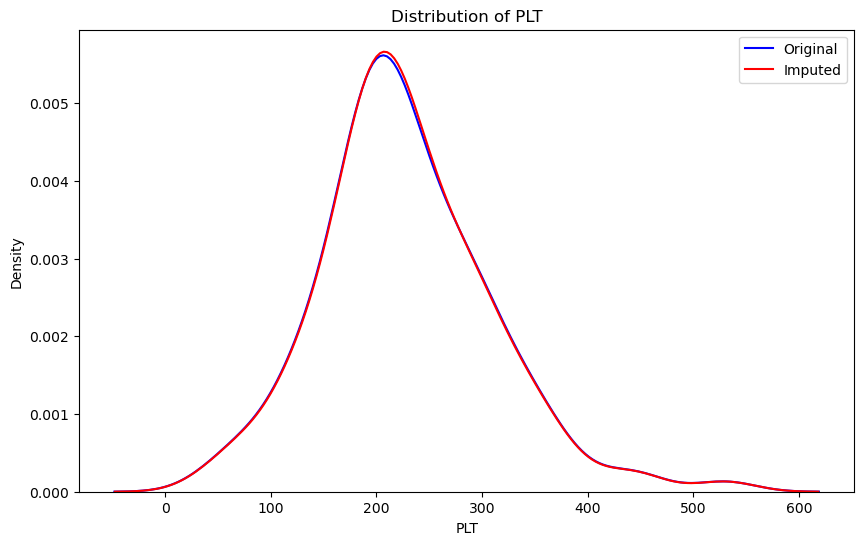

KS Test for PLT: KS Statistic = 0.005206719147089816, p-value = 1.0
The result for PLT is not significant after Bonferroni correction.


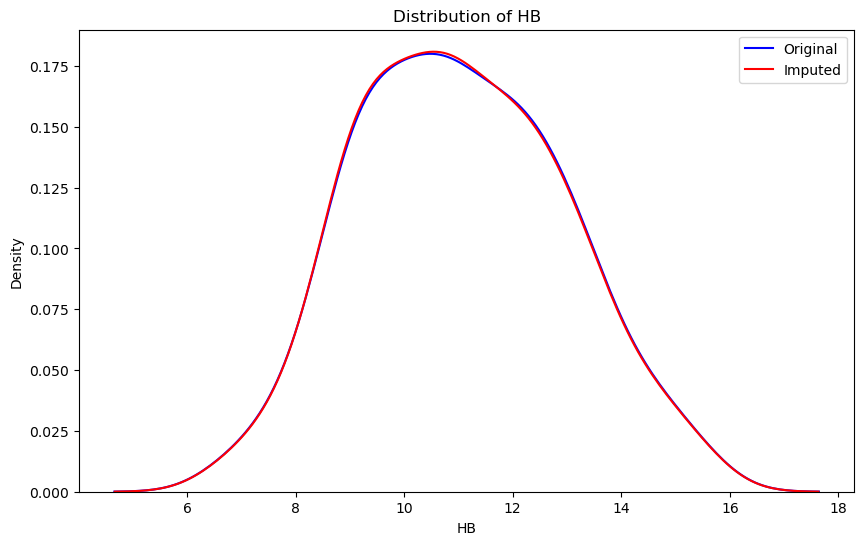

KS Test for HB: KS Statistic = 0.004462902126076985, p-value = 1.0
The result for HB is not significant after Bonferroni correction.


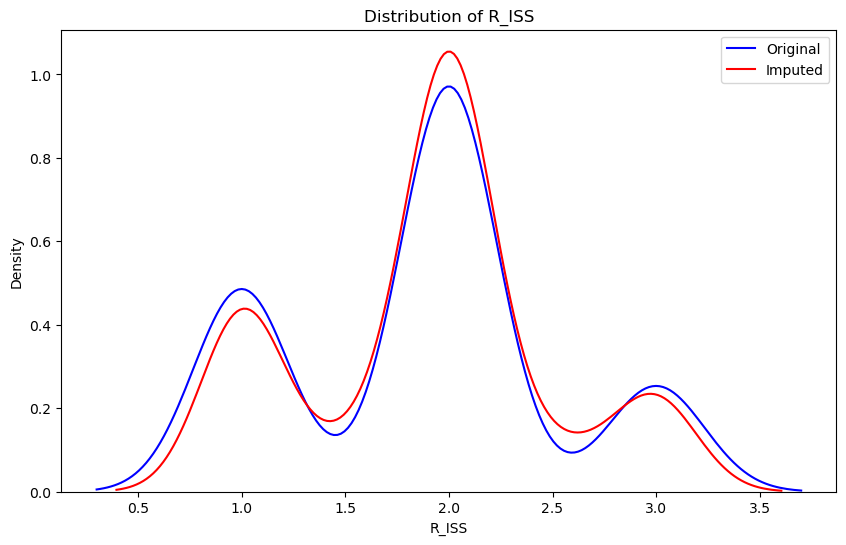

KS Test for R_ISS: KS Statistic = 0.09167085637673873, p-value = 0.38136809734675464
The result for R_ISS is not significant after Bonferroni correction.


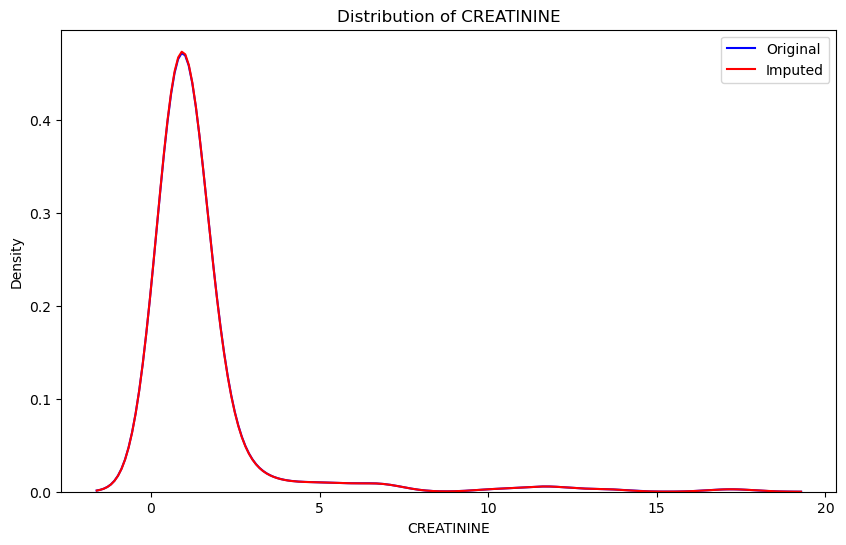

KS Test for CREATININE: KS Statistic = 0.0035170711641299875, p-value = 1.0
The result for CREATININE is not significant after Bonferroni correction.


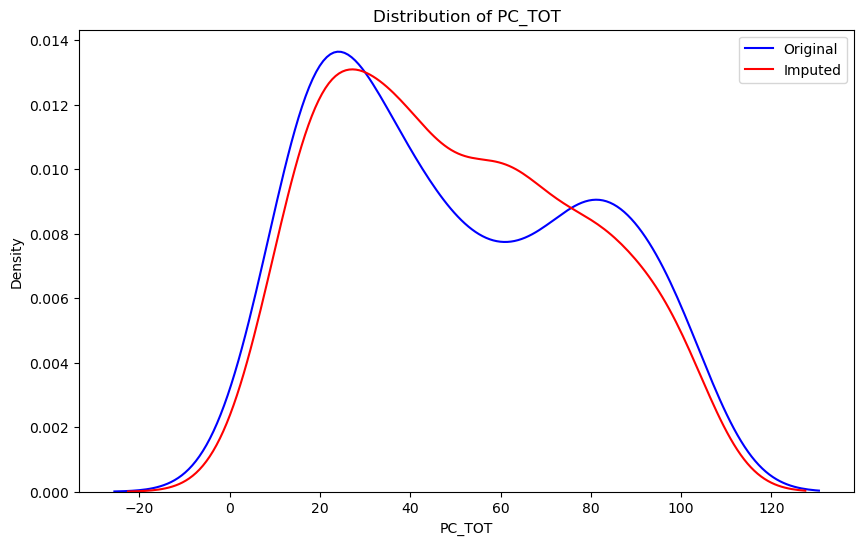

KS Test for PC_TOT: KS Statistic = 0.060453461781735024, p-value = 0.8244795909791254
The result for PC_TOT is not significant after Bonferroni correction.


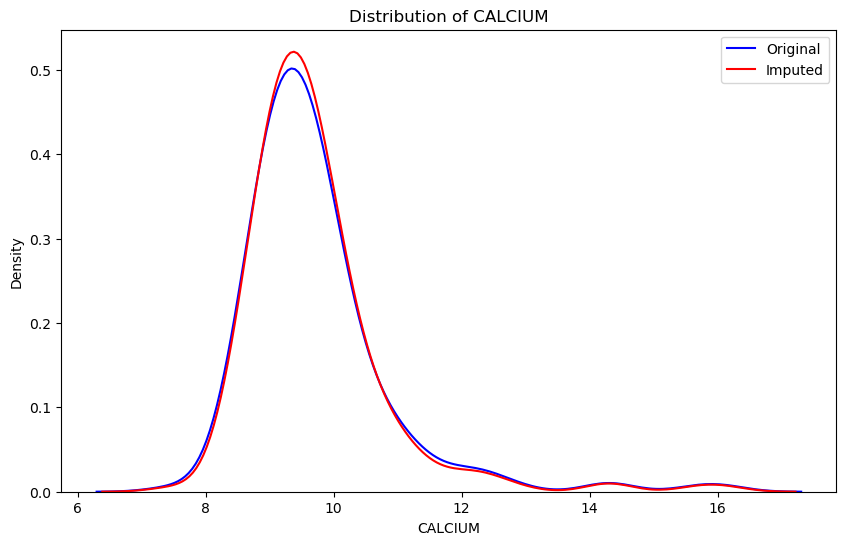

KS Test for CALCIUM: KS Statistic = 0.02098328370806274, p-value = 0.9999999986718252
The result for CALCIUM is not significant after Bonferroni correction.


In [15]:

alpha_originale = 0.05
alpha_nuovo = alpha_originale / len(variables_to_check)

for variable in variables_to_check:
    # Esempio per una variabile specifica
    plot_distributions(data, knn_imputed_data, variable)

    # Test di Kolmogorov-Smirnov per una variabile specifica
    ks_stat, p_value = ks_2samp(data[variable].dropna(), knn_imputed_data[variable])
    print(f"KS Test for {variable}: KS Statistic = {ks_stat}, p-value = {p_value}")
    
    # Verifica se il p-value è significativo con la correzione di Bonferroni
    if p_value < alpha_nuovo:
        print(f"The result for {variable} is significant after Bonferroni correction.")
    else:
        print(f"The result for {variable} is not significant after Bonferroni correction.")


In [16]:
# Conta il numero totale di valori NaN nel dataset
total_nan_count = data.isna().sum().sum()

# Calcola la percentuale di valori NaN nel dataset
total_nan_percentage = (total_nan_count / data.size) * 100

print(f"Total NaN Count: {total_nan_count}")
print(f"Total NaN Percentage: {total_nan_percentage:.2f}%")


Total NaN Count: 127
Total NaN Percentage: 0.05%


In [17]:
# Load the simulated dataset
simulated_data = pd.read_csv('simulated_data.csv')

In [18]:
# Identify columns with missing values
missing_columns = simulated_data.columns[simulated_data.isnull().sum() != 0]

# Print the columns with missing values and their respective counts
for col in missing_columns:
    print(f'{col}: {simulated_data[col].isnull().sum()}')
    print(f'{col}: {simulated_data[col].describe()}')


PLT: 2
PLT: count    219.000000
mean     228.220406
std       81.351354
min       35.000000
25%      179.500000
50%      217.051242
75%      274.500000
max      536.000000
Name: PLT, dtype: float64
HB: 2
HB: count    219.000000
mean      11.045530
std        1.902168
min        6.600000
25%        9.600000
50%       10.900000
75%       12.400000
max       15.700000
Name: HB, dtype: float64
R_ISS: 59
R_ISS: count    162.000000
mean       1.888702
std        0.556660
min        1.000000
25%        1.856920
50%        2.000000
75%        2.026880
max        3.000000
Name: R_ISS, dtype: float64
CREATININE: 1
CREATININE: count    220.000000
mean       1.476453
std        2.040473
min        0.470000
25%        0.740000
50%        0.920000
75%        1.262500
max       17.200000
Name: CREATININE, dtype: float64
PC_TOT: 35
PC_TOT: count    186.000000
mean      49.806939
std       26.470324
min        5.000000
25%       30.000000
50%       44.189748
75%       70.000000
max      100.000000
Name

In [19]:
# Replace NaN values with the mean of each column
# Assume `simulated_data` is your DataFrame with NaN values

# Step 1: Initialize the KNN imputer with the desired number of neighbors
k = 5  # Choose the number of neighbors
knn_imputer = KNNImputer(n_neighbors=k, weights='distance')

# Step 2: Fit and transform the data to replace NaNs
knn_imputed_simulated_data = pd.DataFrame(knn_imputer.fit_transform(simulated_data), columns=simulated_data.columns)



     PFS_I_EVENT  PFS_I_MONTHS  OS_EVENT  OS_MONTH         PLT         HB  \
0            1.0          21.0       1.0      46.0  258.217649  11.249267   
1            1.0           0.0       1.0       1.0  525.000000  10.800000   
2            0.0          26.0       0.0      26.0  294.000000  11.300000   
3            0.0          55.0       0.0      55.0  275.000000  13.000000   
4            1.0           3.0       1.0      29.0  227.000000  10.700000   
..           ...           ...       ...       ...         ...        ...   
216          1.0          41.0       0.0      50.0  289.000000  13.400000   
217          1.0          37.0       1.0      43.0   69.000000   9.300000   
218          1.0          20.0       0.0      59.0  241.000000  11.000000   
219          1.0          21.0       1.0      80.0  281.000000   8.700000   
220          1.0           7.0       0.0      53.0  114.000000   6.900000   

      AGE     R_ISS  SEX  CREATININE  ...  \
0    27.0  3.000000  1.0      

In [39]:
knn_imputed_simulated_data.to_csv('knn_imputed_simulated_data.csv', index=False)

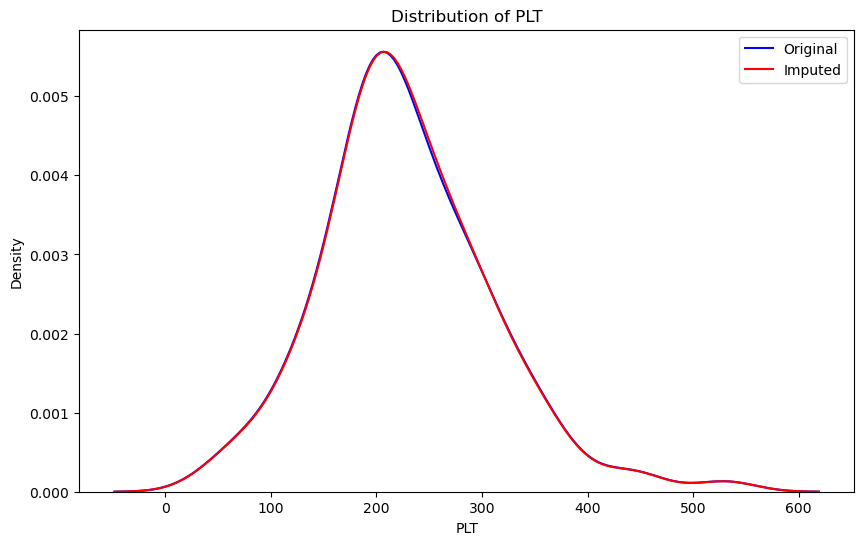

KS Test for PLT: KS Statistic = 0.0055373044897621855, p-value = 1.0
The result for PLT is not significant after Bonferroni correction.


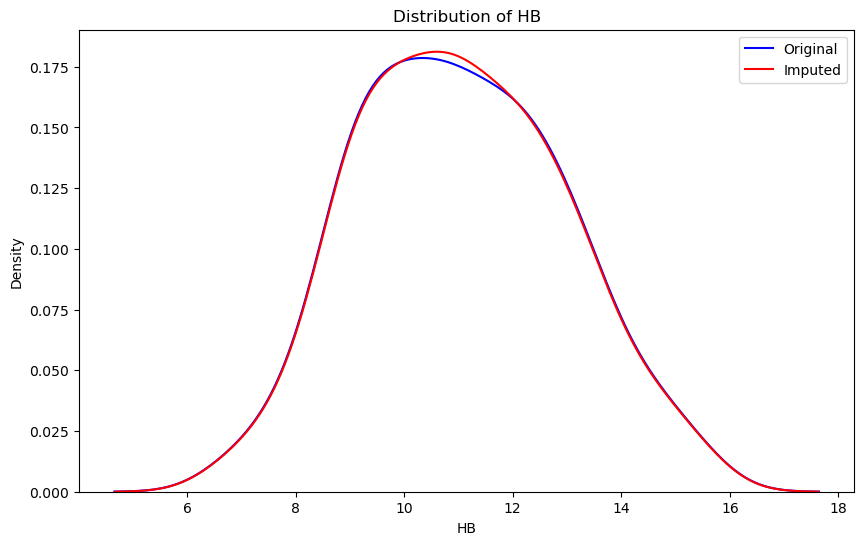

KS Test for HB: KS Statistic = 0.0045042252939110315, p-value = 1.0
The result for HB is not significant after Bonferroni correction.


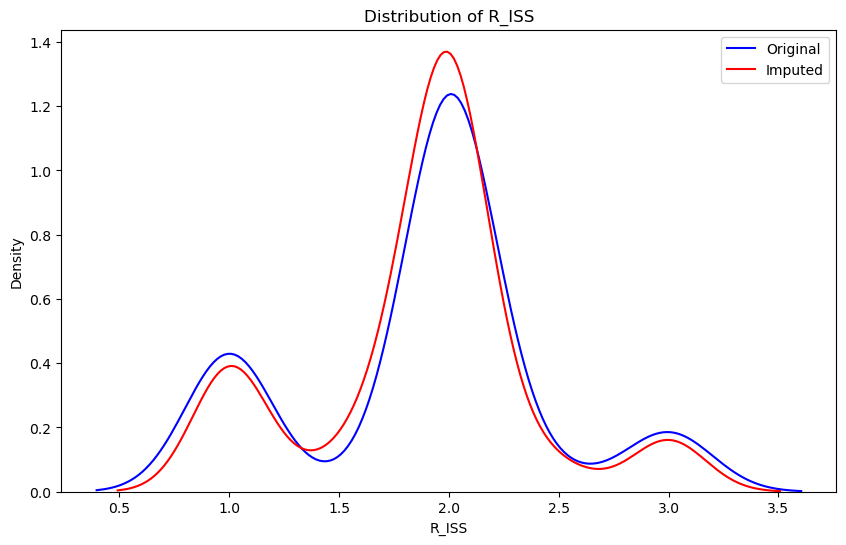

KS Test for R_ISS: KS Statistic = 0.1199932964638847, p-value = 0.12198387146948951
The result for R_ISS is not significant after Bonferroni correction.


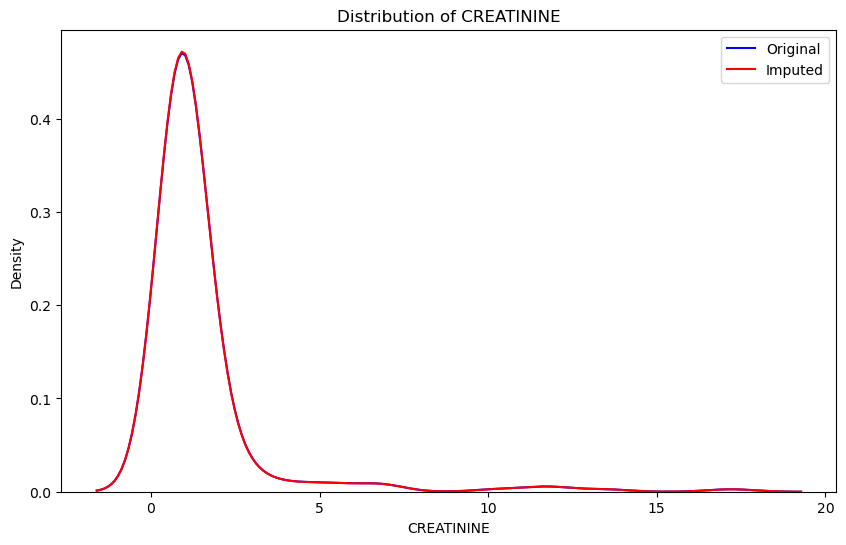

KS Test for CREATININE: KS Statistic = 0.0024064171122994654, p-value = 1.0
The result for CREATININE is not significant after Bonferroni correction.


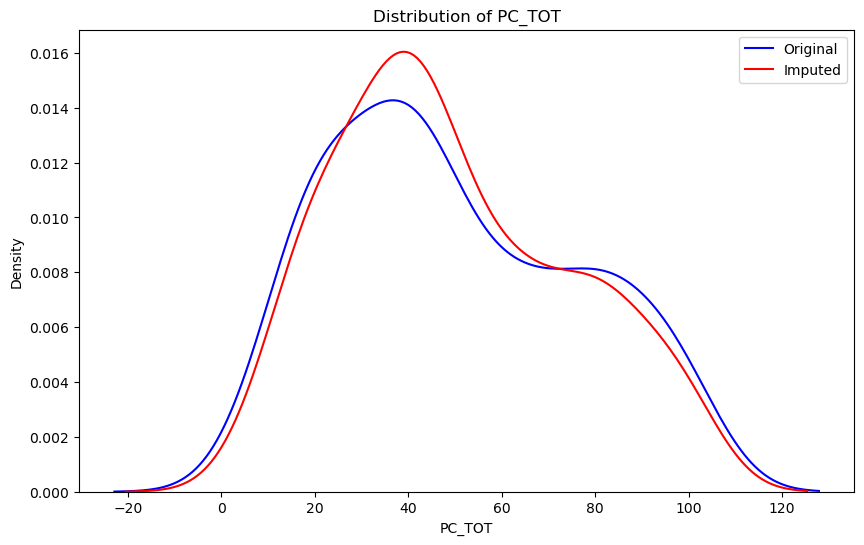

KS Test for PC_TOT: KS Statistic = 0.0411862015277575, p-value = 0.991620779832028
The result for PC_TOT is not significant after Bonferroni correction.


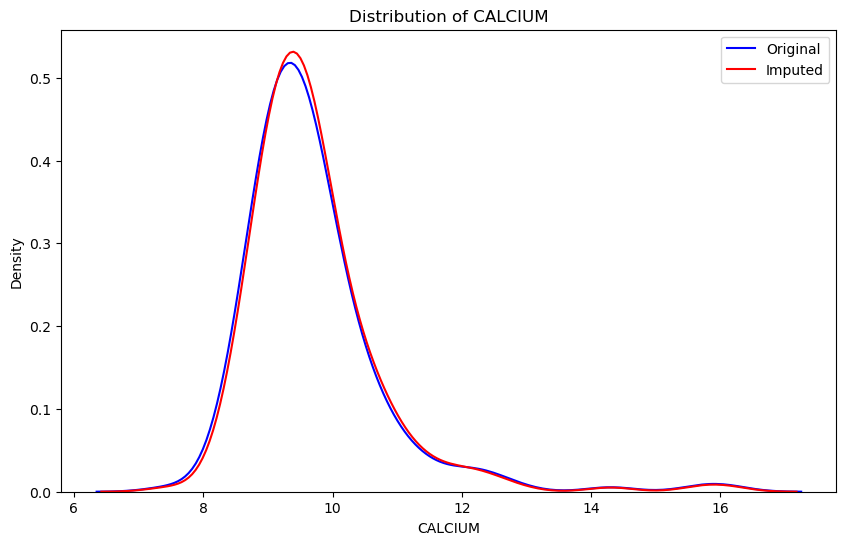

KS Test for CALCIUM: KS Statistic = 0.03390148406911589, p-value = 0.9993654041194031
The result for CALCIUM is not significant after Bonferroni correction.


In [20]:
# Supponiamo che `variables_to_check` sia la lista delle variabili per cui stai eseguendo il test
alpha_originale = 0.05
alpha_nuovo = alpha_originale / len(variables_to_check)
# Identifica le variabili con dati mancanti


for variable in variables_to_check:
    # Esempio per una variabile specifica
    
    # Test di Kolmogorov-Smirnov per una variabile specifica
    ks_stat, p_value = ks_2samp(simulated_data[variable].dropna(), knn_imputed_simulated_data[variable])
    plot_distributions(simulated_data, knn_imputed_simulated_data, variable)
    print(f"KS Test for {variable}: KS Statistic = {ks_stat}, p-value = {p_value}")

    # Verifica se il p-value è significativo con la correzione di Bonferroni
    if p_value < alpha_nuovo:
        print(f"The result for {variable} is significant after Bonferroni correction.")


    else:
        print(f"The result for {variable} is not significant after Bonferroni correction.")
        continue


In [21]:
# Supponiamo che `simulated_data` e `imputed_data` siano i dataframe con i dati simulati e imputati

# Crea una maschera di valori mancanti tra simulated_data e imputed_data
missing_mask = simulated_data.isna() & knn_imputed_simulated_data.notna()

# Stampa la maschera di valori mancanti per verificare
print(missing_mask)


     PFS_I_EVENT  PFS_I_MONTHS  OS_EVENT  OS_MONTH    PLT     HB    AGE  \
0          False         False     False     False  False  False  False   
1          False         False     False     False  False  False  False   
2          False         False     False     False  False  False  False   
3          False         False     False     False  False  False  False   
4          False         False     False     False  False  False  False   
..           ...           ...       ...       ...    ...    ...    ...   
216        False         False     False     False  False  False  False   
217        False         False     False     False  False  False  False   
218        False         False     False     False  False  False  False   
219        False         False     False     False  False  False  False   
220        False         False     False     False  False  False  False   

     R_ISS    SEX  CREATININE  ...  wavelet-LLL_gldm_GrayLevelNonUniformity  \
0    False  False   

In [22]:
# Step 3: Calcolo dell'RMSE
def calculate_rmse(original, imputed, mask):
    # Appiattisci i DataFrame per confrontare i valori
    original_flat = original.values.flatten()
    imputed_flat = imputed.values.flatten()
    mask_flat = mask.values.flatten()
    print(mask_flat)
    # Filtra solo i valori che erano mancanti nell'originale
    original_missing = original_flat[mask_flat]
    imputed_missing = imputed_flat[mask_flat]
    
    # Calcola l'RMSE
    rmse = np.sqrt(np.mean((original_missing - imputed_missing) ** 2))
    return rmse

# Esempio di utilizzo
rmse_value = calculate_rmse(knn_imputed_data, knn_imputed_simulated_data, missing_mask)
print(f"RMSE: {rmse_value}")


[False False False ... False False False]
RMSE: 16.78683811100798


In [23]:
# Calcola l'RMSE per ogni variabile con valori mancanti
rmse_scores = {}
for variable in variables_to_check:
    print(variable)
    original_values = knn_imputed_data.loc[simulated_data[variable].isnull(), variable]
    #print(original_values)
    imputed_values = knn_imputed_simulated_data.loc[simulated_data[variable].isnull(), variable]
    #print(imputed_values)
    original_flat = original_values.values.flatten()
    print(original_flat)
    imputed_flat = imputed_values.values.flatten()
    print(imputed_flat)
    if original_flat.any():
        rmse = np.sqrt(np.mean((original_flat - imputed_flat) ** 2))
        rmse_scores[variable] = rmse

# Stampa i risultati dell'RMSE per ogni variabile
for variable, rmse in rmse_scores.items():
    print(f"RMSE for {variable}: {rmse}")

PLT
[217. 216.]
[240.36310714 259.63035732]
HB
[10.6 10.8]
[10.8617591  11.07911072]
R_ISS
[1.         2.20903868 3.         1.         3.         1.
 2.         2.         1.         2.         2.         2.
 3.         2.         1.60699171 1.         2.         3.
 2.         1.         2.         3.         2.         1.
 3.         3.         2.68716903 1.         1.         1.
 2.52230393 2.         1.         1.89845545 2.         1.81321826
 2.         2.49315514 2.         2.         2.         2.14912202
 1.8056364  2.         2.         2.         2.         1.17234061
 2.         2.         3.         2.         2.         1.18170582
 1.81445734 1.73328635 1.86491246 2.12485355 3.        ]
[1.86621305 2.20907145 1.90779315 1.63449445 2.58403919 1.74612697
 1.7810436  2.10268099 2.02285079 2.26028186 1.84456296 1.16687352
 1.59357275 1.93278953 1.19203618 1.90451646 1.51311859 1.93722172
 2.11668555 1.74016406 2.21968651 1.84432928 1.90177095 1.72705749
 1.98555178 1.8485551

In [24]:
import numpy as np

def calculate_msep(original_data, data_without_missing, imputed_data, variables_to_check):
    msep_scores = {}
    
    for variable in variables_to_check:
        # Create a binary mask where missing values were originally located
        missing_mask = original_data[variable].isnull()
        print(missing_mask)
        # Extract the original and imputed values for the missing entries
        original_values = data_without_missing.loc[missing_mask, variable]
        imputed_values = imputed_data.loc[missing_mask, variable]
        
        # Calculate the MSEP score
        squared_errors = (original_values - imputed_values) ** 2
        percentage_errors = squared_errors / original_values ** 2
        msep = np.mean(percentage_errors) * 100  # Convert to percentage
        msep_scores[variable] = msep
    
    return msep_scores

# Esempio di utilizzo:
# Supponiamo che `data_with_missing` sia il dataset originale con valori mancanti
# e `missing_imputed` sia il dataset con i valori imputati da missForest

# Calcola il MSEP per ogni variabile con dati mancanti
msep_results = calculate_msep(simulated_data, knn_imputed_data, knn_imputed_simulated_data, variables_to_check)

# Stampa i risultati del MSEP
for variable, msep in msep_results.items():
    print(f"MSEP for {variable}: {msep:.2f}%")


0      False
1      False
2      False
3      False
4      False
       ...  
216    False
217    False
218    False
219    False
220    False
Name: PLT, Length: 221, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
216    False
217    False
218    False
219    False
220    False
Name: HB, Length: 221, dtype: bool
0      False
1      False
2       True
3      False
4      False
       ...  
216    False
217    False
218    False
219     True
220    False
Name: R_ISS, Length: 221, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
216    False
217    False
218    False
219    False
220    False
Name: CREATININE, Length: 221, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
216    False
217     True
218    False
219    False
220    False
Name: PC_TOT, Length: 221, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
216    False
217

PLT
[217. 216.]
[240.36310714 259.63035732]
[0.10766409 0.20199239]
HB
[10.6 10.8]
[10.8617591  11.07911072]
[0.02469425 0.02584358]
R_ISS
[1.         2.20903868 3.         1.         3.         1.
 2.         2.         1.         2.         2.         2.
 3.         2.         1.60699171 1.         2.         3.
 2.         1.         2.         3.         2.         1.
 3.         3.         2.68716903 1.         1.         1.
 2.52230393 2.         1.         1.89845545 2.         1.81321826
 2.         2.49315514 2.         2.         2.         2.14912202
 1.8056364  2.         2.         2.         2.         1.17234061
 2.         2.         3.         2.         2.         1.18170582
 1.81445734 1.73328635 1.86491246 2.12485355 3.        ]
[1.86621305 2.20907145 1.90779315 1.63449445 2.58403919 1.74612697
 1.7810436  2.10268099 2.02285079 2.26028186 1.84456296 1.16687352
 1.59357275 1.93278953 1.19203618 1.90451646 1.51311859 1.93722172
 2.11668555 1.74016406 2.21968651 1.8443

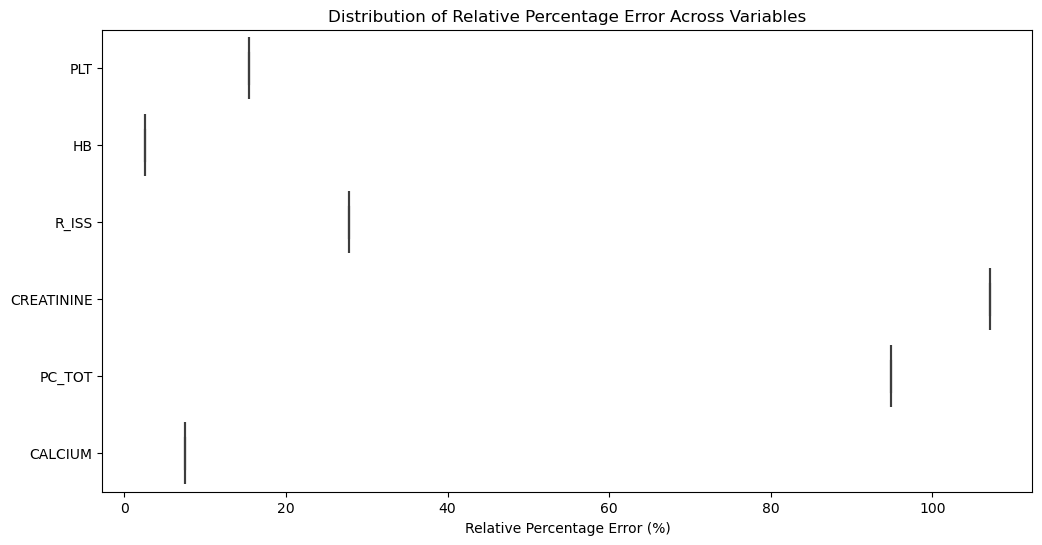

Percentage Average Relative Error for PLT: 15.48%
Percentage Average Relative Error for HB: 2.53%
Percentage Average Relative Error for R_ISS: 27.78%
Percentage Average Relative Error for CREATININE: 107.15%
Percentage Average Relative Error for PC_TOT: 94.89%
Percentage Average Relative Error for CALCIUM: 7.53%


In [37]:
# Calcola gli errori relativi medi percentuali per ogni variabile con valori mancanti
percentage_errors = {}
for variable in variables_to_check:
    #print(variable)
    original_values = knn_imputed_data.loc[simulated_data[variable].isnull(), variable]

    imputed_values = knn_imputed_simulated_data.loc[simulated_data[variable].isnull(), variable]

    original_flat = original_values.values.flatten()

    imputed_flat = imputed_values.values.flatten()

    if original_flat.any():
#         print(original_flat)
#         print(imputed_flat)
        relative_errors = np.abs((original_flat - imputed_flat) / original_flat)
#         print(relative_errors)
        percentage_error = np.mean(relative_errors) * 100
        percentage_errors[variable] = percentage_error
        
# Convert the dictionary to a DataFrame for easier plotting
errors_df = pd.DataFrame.from_dict(percentage_errors, orient='index').transpose()

# Plot a box plot for relative percentage errors across all variables
plt.figure(figsize=(12, 6))
sns.boxplot(data=errors_df, orient="h")
plt.xlabel("Relative Percentage Error (%)")
plt.title("Distribution of Relative Percentage Error Across Variables")
plt.show()

# Stampa i risultati degli errori relativi medi percentuali per ogni variabile
for variable, error in percentage_errors.items():
    print(f"Percentage Average Relative Error for {variable}: {error:.2f}%")

In [26]:
# Calcola l'errore relativo medio percentuale per tutte le variabili con valori mancanti
original_values = []
imputed_values = []

for variable in variables_to_check:
    original_values.extend(knn_imputed_data.loc[simulated_data[variable].isnull(), variable].values.flatten())
    imputed_values.extend(knn_imputed_simulated_data.loc[simulated_data[variable].isnull(), variable].values.flatten())

original_values = np.array(original_values)
imputed_values = np.array(imputed_values)

relative_errors = np.abs((original_values - imputed_values) / original_values)
percentage_error = np.mean(relative_errors) * 100

# Stampa il risultato dell'errore relativo medio percentuale
print(f"Percentage Average Relative Error: {percentage_error:.2f}%")

Percentage Average Relative Error: 41.84%


In [27]:
def calculate_mae(original_data, data_without_missing, imputed_data, variables_to_check):
    mae_scores = {}
    
    for variable in variables_to_check:
        # Create a binary mask where missing values were originally located
        missing_mask = original_data[variable].isnull()
        
        # Extract the original and imputed values for the missing entries
        original_values = data_without_missing.loc[missing_mask, variable]
        imputed_values = imputed_data.loc[missing_mask, variable]
        
        # Calculate the MAE score
        mae = mean_absolute_error(original_values, imputed_values)
        mae_scores[variable] = mae
    
    return mae_scores

# Esempio di utilizzo:
# Supponiamo che `data_with_missing` sia il dataset originale con valori mancanti
# e `missing_imputed` sia il dataset con i valori imputati da missForest



# Calcola il MAE per ogni variabile con dati mancanti
mae_results = calculate_mae(simulated_data, knn_imputed_data, knn_imputed_simulated_data, variables_to_check)

# Stampa i risultati del MAE
for variable, mae in mae_results.items():
    print(f"MAE for {variable}: {mae}")



MAE for PLT: 33.49673222564422
MAE for HB: 0.270434908338542
MAE for R_ISS: 0.45950259307068464
MAE for CREATININE: 0.5036110319491285
MAE for PC_TOT: 25.692001861587805
MAE for CALCIUM: 0.7743631441546858


In [28]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Assume imputed_data is the original data, imputed_simulated_data is the dataset with imputed values
# and missing_mask indicates the positions of simulated missing values.

# Initialize lists to hold correlation values for each variable
pearson_correlations = []
spearman_correlations = []

# Iterate over each column to calculate correlations at missing locations
for column in simulated_data.columns:
    # Extract original and imputed values at missing positions for this column
    original_values = knn_imputed_data[column][missing_mask[column]]
    imputed_values = knn_imputed_simulated_data[column][missing_mask[column]]
    
    # Only calculate correlation if there are at least two valid data points
    if len(original_values) > 1 and not original_values.isnull().all() and not imputed_values.isnull().all():
        # Calculate Pearson correlation (linear)
        pearson_corr, _ = pearsonr(original_values, imputed_values)
        pearson_correlations.append(pearson_corr)

        # Calculate Spearman correlation (monotonic)
        spearman_corr, _ = spearmanr(original_values, imputed_values)
        spearman_correlations.append(spearman_corr)

# Aggregate results (e.g., mean or median correlation across all variables)
mean_pearson_corr = np.mean(pearson_correlations)
mean_spearman_corr = np.mean(spearman_correlations)

print(f"Mean Pearson Correlation: {mean_pearson_corr}")
print(f"Mean Spearman Correlation: {mean_spearman_corr}")


Mean Pearson Correlation: 0.08517199992855695
Mean Spearman Correlation: 0.11679120865810406


In [29]:
missing_mask_data = data.isna() & knn_imputed_data.notna()

In [30]:
import pandas as pd
import numpy as np

# Step 1: Calculate the pairwise correlation matrix using available data before imputation
correlation_matrix_before = data.corr()  # Automatically ignores NaNs


# Step 3: Calculate the pairwise correlation matrix after imputation
correlation_matrix_after = knn_imputed_data.corr()

# Step 4: Compute the absolute difference between the two correlation matrices
correlation_diff = np.abs(correlation_matrix_before - correlation_matrix_after)

# Step 5: Summarize the differences to assess overall similarity
mean_correlation_difference = correlation_diff.mean().mean()
median_correlation_difference = correlation_diff.median().median()

print(f"Mean Correlation Difference: {mean_correlation_difference}")
print(f"Median Correlation Difference: {median_correlation_difference}")


Mean Correlation Difference: 6.524894596367485e-05
Median Correlation Difference: 0.0


Small Mean/Median Correlation Difference: Indicates that the imputation method preserved the original data’s correlation structure well.

In [31]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# Convert correlation matrices to distance matrices
dist_before = pdist(correlation_matrix_before, metric='euclidean')
dist_after = pdist(correlation_matrix_after, metric='euclidean')

# Compute the correlation between the two distance matrices
mantel_corr, p_value = pearsonr(dist_before, dist_after)

print(f"Mantel Correlation: {mantel_corr}")
print(f"P-value: {p_value}")


Mantel Correlation: 0.9999986615589217
P-value: 0.0


In [32]:
import numpy as np

# Vectorize the correlation matrices
vec_before = correlation_matrix_before.values.flatten()
vec_after = correlation_matrix_after.values.flatten()

# Compute the RV coefficient as a correlation between vectorized matrices
rv_coefficient = np.corrcoef(vec_before, vec_after)[0, 1]

print(f"RV Coefficient: {rv_coefficient}")


RV Coefficient: 0.9999964978417042


In [33]:
frobenius_norm = np.linalg.norm(correlation_matrix_before - correlation_matrix_after, 'fro')
print(f"Frobenius Norm of Matrix Difference: {frobenius_norm}")


Frobenius Norm of Matrix Difference: 1.349417495458543


In [34]:
from sklearn.decomposition import PCA

# Apply PCA on the correlation matrices
pca = PCA(n_components=5)
pca_before = pca.fit_transform(correlation_matrix_before)
pca_after = pca.fit_transform(correlation_matrix_after)

# Compute similarity between the principal components
principal_component_similarity = np.corrcoef(pca_before[:, 0], pca_after[:, 0])[0, 1]
principal_component_similarity_1 = np.corrcoef(pca_before[:, 1], pca_after[:, 1])[0, 1]
principal_component_similarity_2 = np.corrcoef(pca_before[:, 2], pca_after[:, 2])[0, 1]
principal_component_similarity_3 = np.corrcoef(pca_before[:, 3], pca_after[:, 3])[0, 1]
principal_component_similarity_4 = np.corrcoef(pca_before[:, 4], pca_after[:, 4])[0, 1]
print(f"Principal Component Similarity (1st component): {principal_component_similarity}")
print(f"Principal Component Similarity (2st component): {principal_component_similarity_1}")
print(f"Principal Component Similarity (3st component): {principal_component_similarity_2}")
print(f"Principal Component Similarity (4st component): {principal_component_similarity_3}")
print(f"Principal Component Similarity (5st component): {principal_component_similarity_4}")


Principal Component Similarity (1st component): 0.9999997725349894
Principal Component Similarity (2st component): 0.9999948009115179
Principal Component Similarity (3st component): 0.9999991878139682
Principal Component Similarity (4st component): 0.9997135754737941
Principal Component Similarity (5st component): 0.9997128688035593


In [35]:
from sklearn.decomposition import PCA
import numpy as np

# Define the number of principal components to compare
n_components = 5

# Run PCA on the original and imputed datasets
pca_before = PCA(n_components=n_components).fit(data.dropna())
pca_after = PCA(n_components=n_components).fit(knn_imputed_data)

# Extract the principal components (loadings) for comparison
components_before = pca_before.components_
components_after = pca_after.components_

# Calculate Frobenius norm of the difference between the two component matrices
frobenius_norm_pca = np.linalg.norm(components_before - components_after, 'fro')
print(f"Frobenius Norm of Principal Component Difference: {frobenius_norm_pca}")


Frobenius Norm of Principal Component Difference: 0.28079049064722267


In [36]:
# Step 1: Calculate the pairwise correlation matrix using available data before imputation
correlation_matrix_before = simulated_data.corr()  # Automatically ignores NaNs


# Step 3: Calculate the pairwise correlation matrix after imputation
correlation_matrix_after = knn_imputed_simulated_data.corr()

# Step 4: Compute the absolute difference between the two correlation matrices
correlation_diff = np.abs(correlation_matrix_before - correlation_matrix_after)

# Step 5: Summarize the differences to assess overall similarity
mean_correlation_difference = correlation_diff.mean().mean()
median_correlation_difference = correlation_diff.median().median()

print(f"Mean Correlation Difference: {mean_correlation_difference}")
print(f"Median Correlation Difference: {median_correlation_difference}")


Mean Correlation Difference: 6.10462425393639e-05
Median Correlation Difference: 0.0


In [38]:
import numpy as np

# Assume correlation_matrix1 and correlation_matrix2 are your two correlation matrices
# These should be numpy arrays or pandas DataFrames representing the correlation matrices

# Step 1: Calculate the eigenvalues of both matrices
eigenvalues1 = np.linalg.eigvalsh(correlation_matrix_before)  # Sorted eigenvalues for correlation_matrix1
eigenvalues2 = np.linalg.eigvalsh(correlation_matrix_after)  # Sorted eigenvalues for correlation_matrix2

# Step 2: Calculate the Euclidean distance between the sets of eigenvalues
eigenvalue_distance = np.linalg.norm(eigenvalues1 - eigenvalues2)

print(f"Euclidean Distance between Eigenvalues: {eigenvalue_distance}")

Euclidean Distance between Eigenvalues: 0.09864944245137974


A smaller distance suggests that the two matrices have a similar structure in terms of correlation patterns.